### Simulate models and compare results
This notebook simulates the predictions from the various models. Then we comapre the findings with the aim to pick the most appropriate one

### Import libraries and set global params

In [1]:
%load_ext nb_black
%matplotlib inline
import os
import pandas as pd
import pickle
from pathlib import Path
from datetime import datetime

from arenkods.ml.plot import validation_metrics_plots, predictions_plots
from arenkods.ml.validation import validation_metrics

from m7_price_predictions.utils import data_handling
from m7_price_predictions.tuning import run
from m7_price_predictions.models._EmpiricalBaseline import EmpiricalBaseline
from m7_price_predictions.models._QuantileLR import QuantileLR
from m7_price_predictions.models._QuantileNN import QuantileNN
from m7_price_predictions.models._QuantileGBM import QuantileGBM
from m7_price_predictions.models._QuantileRF import QuantileRF

import warnings

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

### Define the simulation parameters

In [2]:
# The models you want to simulate
# MODELS = ["EmpiricalBaseline", "QuantileLR", "QuantileNN", "QuantileRF"]
# MODELS = ["QuantileLR", "QuantileNN", "QuantileRF"]
MODELS = ["QuantileNN"]  # , "QuantileRF"]

# The no of periods you want to load features for
N_PERIODS = 11

# The periods you want to examine
PERIODS_TO_EXAMINE = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

# The directory to save/load the results dictionaries
RESULTS_PATH = Path().cwd() / "results"
PLOTS_PATH = Path().cwd() / "results" / "plots"


# True for new simulations, False to use saved results
NEW_RESULTS = True

<IPython.core.display.Javascript object>

### Define the Case to simulate
#### Saved cases list:
- <b>NewFeatures</b>: All models over train/val data
- <b>NewFeatures_no_bsln</b>: All models excl Baseline over train/val data
- <b>NewFeatures_no_bsln_test</b>: All models excl Baseline over train/test data
- <b>Original</b>: All models over train/val data
- <b>Original_RF_NN</b>: All models excl Baseline over train/val data
- <b>Original_test</b>: All models excl Baseline over train/val data
- <b>Original_RF_NN_test</b>: All models excl Baseline over train/val data

#### Notes for case selection
1. If the case name contains the word "test" then it is running over the test data (out-of-sample). If it does not then it runs over the validation data
2. When you switch between original featueres and new features, make sure you update the path in utils/constants.py to point to the right folder for the hyper_params and data
3. Update the list of models to evaluate if you want additional/fewer models to evaluate


In [3]:
# Select Case
CASE = "Jan_NN_test"

<IPython.core.display.Javascript object>

### Load the features

In [4]:
features_dict = run._get_feature_dict(nperiods=N_PERIODS)

[INFO |run.py] - Asked for 11 periods ahead - 11 periods are available in the saved data. 11 will be used


<IPython.core.display.Javascript object>

In [5]:
def get_restuls_dict(X, y, period):
    """ Function to simulate all models"""
    results = {}
    for model in MODELS:
        model = eval(model)(period)
        print("Simulating ", model.__class__.__name__, " ...")
        results["%s" % model.__class__.__name__] = model.simulate(X, y)
    return results


def get_X_y(features):
    """ Returns X (features), y(target) needed for simulations """
    data = data_handling.split_data(features)
    if "test" in CASE:
        test_val = "test"
    else:
        test_val = "val"
    X = pd.concat([data["X_train"], data["X_" + test_val]])
    y = pd.concat([data["y_train"], data["y_" + test_val]])
    return X, y


def save_results(full_results, fname="results.pickle"):
    with open(RESULTS_PATH / fname, "wb") as handle:
        pickle.dump(full_results, handle, protocol=pickle.HIGHEST_PROTOCOL)


def load_results(fname="results.pickle"):
    with open(RESULTS_PATH / fname, "rb") as handle:
        return pickle.load(handle)


def plot_metrics(full_results):
    save_dir = PLOTS_PATH / "metrics"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    plot_dict = {}
    for period in full_results.keys():
        plot_dict[period] = validation_metrics_plots.all_metrics_plots(
            full_results[period],
            save_directory=save_dir,
            filename="metrics_" + CASE + "_" + str(period) + ".png",
            title_case=CASE,
        )
    return plot_dict


def plot_predictions(full_results):
    save_dir = PLOTS_PATH / "predictions"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    plot_dict = {}
    for period in full_results.keys():
        plot_dict[period] = {}
        for model in full_results[period].keys():
            df = full_results[period][model]
            start = df.index[-(48 * 25)]
            end = df.index[-1]
            plot_dict[period][model] = predictions_plots.predictions_plotly(
                df=df.loc[start:end],
                save_directory=save_dir,
                filename="predictions_" + CASE + "_" + str(period) + model + ".html",
                title_case=CASE + "_" + model,
            )

        # plot_period_dict[period] = plot_model_dict
    return plot_dict

<IPython.core.display.Javascript object>

### Collect all the results in one dictionary

In [6]:
full_results = {}
if NEW_RESULTS:
    for period in sorted(features_dict.keys()):
        if period in PERIODS_TO_EXAMINE:
            print("Examining period ", period)
            X, y = get_X_y(features_dict[period])
            full_results[period] = get_restuls_dict(X, y, period)
    save_results(full_results,fname="results_"+CASE+"_.pickle")
else:
    full_results = load_results(fname="results_"+CASE+"_.pickle")



Examining period  3
Simulating  QuantileNN  ...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


Epoch 00068: early stopping


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


Examining period  4
Simulating  QuantileNN  ...
Epoch 00071: early stopping
Epoch 00094: early stopping
Epoch 00083: early stopping
Epoch 00089: early stopping
Examining period  5
Simulating  QuantileNN  ...


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


Examining period  6
Simulating  QuantileNN  ...


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


Examining period  7
Simulating  QuantileNN  ...
Epoch 00113: early stopping
Epoch 00116: early stopping
Epoch 00144: early stopping
Epoch 00147: early stopping
Examining period  8
Simulating  QuantileNN  ...


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


Examining period  9
Simulating  QuantileNN  ...
Epoch 00128: early stopping
Epoch 00134: early stopping
Epoch 00141: early stopping
Epoch 00147: early stopping
Examining period  10
Simulating  QuantileNN  ...


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


Epoch 00117: early stopping
Epoch 00116: early stopping
Epoch 00125: early stopping


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


Examining period  11
Simulating  QuantileNN  ...
Epoch 00107: early stopping
Epoch 00117: early stopping
Epoch 00120: early stopping
Examining period  12
Simulating  QuantileNN  ...


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


Epoch 00113: early stopping
Epoch 00116: early stopping
Epoch 00127: early stopping
Epoch 00162: early stopping
Epoch 00139: early stopping
Examining period  13
Simulating  QuantileNN  ...


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


Epoch 00068: early stopping
Epoch 00127: early stopping
Epoch 00107: early stopping
Epoch 00126: early stopping


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.6s finished


<IPython.core.display.Javascript object>

### Save the metrics outputs

In [7]:
%%capture
plot_dict = plot_metrics(full_results)

<IPython.core.display.Javascript object>

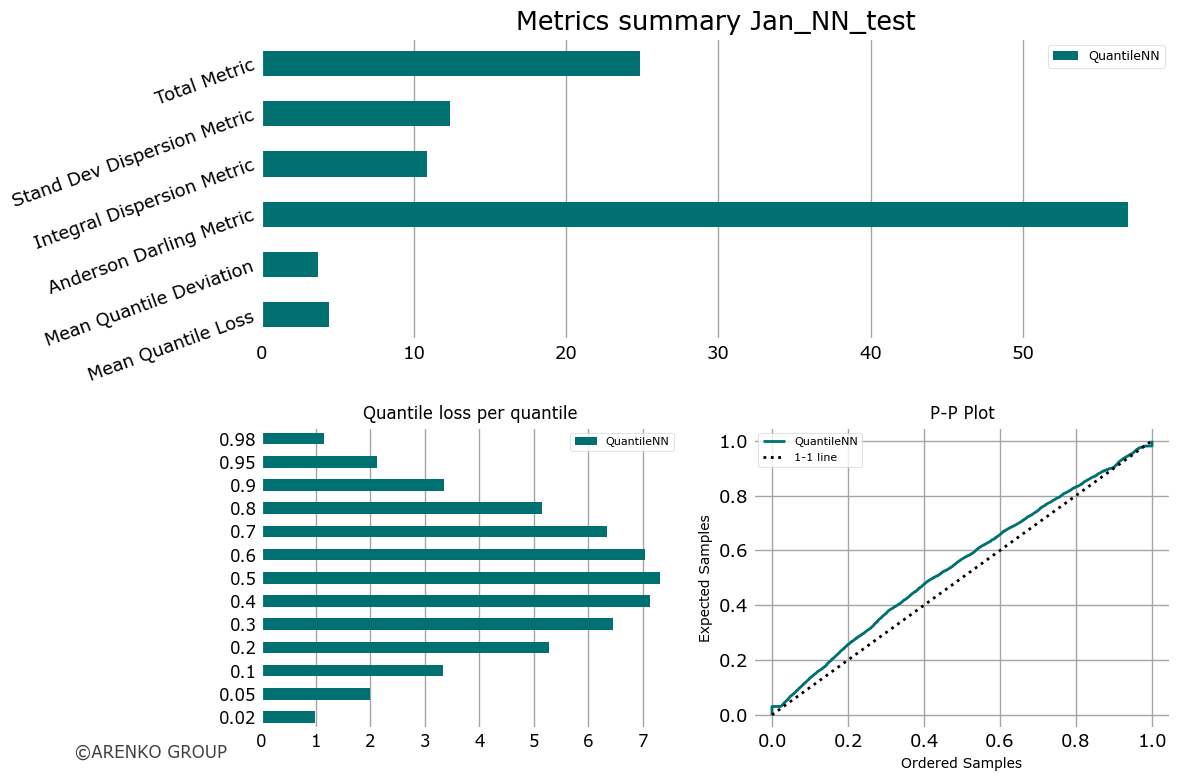

<IPython.core.display.Javascript object>

In [8]:
# Show the metrics for any of the periods
plot_dict[3]

### Save the prediction plots

In [ ]:
%%capture
plot_pred_dict = plot_predictions(full_results)

In [ ]:
# Show the plot of any model
plot_pred_dict[3]["QuantileNN"]

In [9]:
full_results

{3: {'QuantileNN':                                 0.02       0.05        0.1        0.2  \
  Date                                                                    
  2020-09-28 00:00:00+00:00   3.277073   8.286564  12.676006  17.600727   
  2020-09-28 00:30:00+00:00   5.510413  10.428123  15.102764  20.409512   
  2020-09-28 01:00:00+00:00  12.397397  17.361801  22.631937  28.345713   
  2020-09-28 01:30:00+00:00   9.537422  15.420012  20.883390  26.641720   
  2020-09-28 02:00:00+00:00   5.129171  10.667871  15.888240  21.644535   
  ...                              ...        ...        ...        ...   
  2021-01-31 21:30:00+00:00  16.499807  21.732079  26.635490  33.893990   
  2021-01-31 22:00:00+00:00   4.022462   9.307432  13.994570  21.250223   
  2021-01-31 22:30:00+00:00   0.160185   5.775827   9.253203  15.663020   
  2021-01-31 23:00:00+00:00   5.609352   9.512018  12.796905  19.028435   
  2021-01-31 23:30:00+00:00  11.247236  15.393572  19.374134  26.298025   
  
     

<IPython.core.display.Javascript object>